In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
from itertools import product

from polarization_controller import mzi, polarization_splitter_rotator, phase_aligner, edge_coupler, optical_fiber, optical_connector, bidi_tx, bidi_rx, polarization_bidi_single_fiber, polarization_bidi_double_fiber, polarization_bidi

from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [2]:
p_bidi_sf = polarization_bidi_single_fiber()
p_bidi_df = polarization_bidi_double_fiber()
p_bidi = polarization_bidi()

In [3]:
sample_points = 201

voltages = np.linspace(0, 3, sample_points)
phase_shifts = np.linspace(-np.pi, np.pi, sample_points)

rotation_rx = phase_shifts[np.random.permutation(sample_points)]
rotation_ry = phase_shifts[np.random.permutation(sample_points)]
rotation_rz = phase_shifts[np.random.permutation(sample_points)]
rotation_delta = phase_shifts[np.random.permutation(sample_points)]

p_bidi_sf.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])

p_bidi_sf.recursive_update()

In [4]:
def objective_function_sf(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi_sf.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi_sf.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi_sf.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi_sf.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi_sf.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi_sf.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi_sf.recursive_update()

  output_state = p_bidi_sf.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_bottom_port

def plot_optimization(params):
  iters = np.arange(len(params))
  params = np.array(params)
  labels = ['PA-1:XPS1', 'PA-1:XPS2', 'MZI-1:XPS1', 'MZI-1: XPS2', 'MZI-2:XPS1', 'MZI-2: XPS2']
  plt.figure(figsize=(7.5, 8), dpi=400)
  plt.subplot(2, 1, 1)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 0:6], label=labels)
  else:
    plt.plot(iters, params[:, 0:4], label=labels[0:4])

  plt.ylabel('Voltage [V]')
  plt.xlabel('Iteration number')
  plt.legend(fontsize=12)
  plt.grid(True, which="both", ls="dashed", color='.9')

  labels = [
      "Reflected Top port",
      "Reflected Bottom port",
      "Transmitted Top port",
      "Transmitted Bottom port"
  ]
  plt.subplot(2, 1, 2)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 12:], label=labels)
  else:
    plt.plot(iters, params[:, 8:], label=labels)

  plt.ylabel('transmission')
  plt.xlabel('Iteration number')
  # plt.ylim([0, 0.25])
  plt.legend(fontsize=10)
  plt.grid(True, which="both", ls="dashed", color='.9')

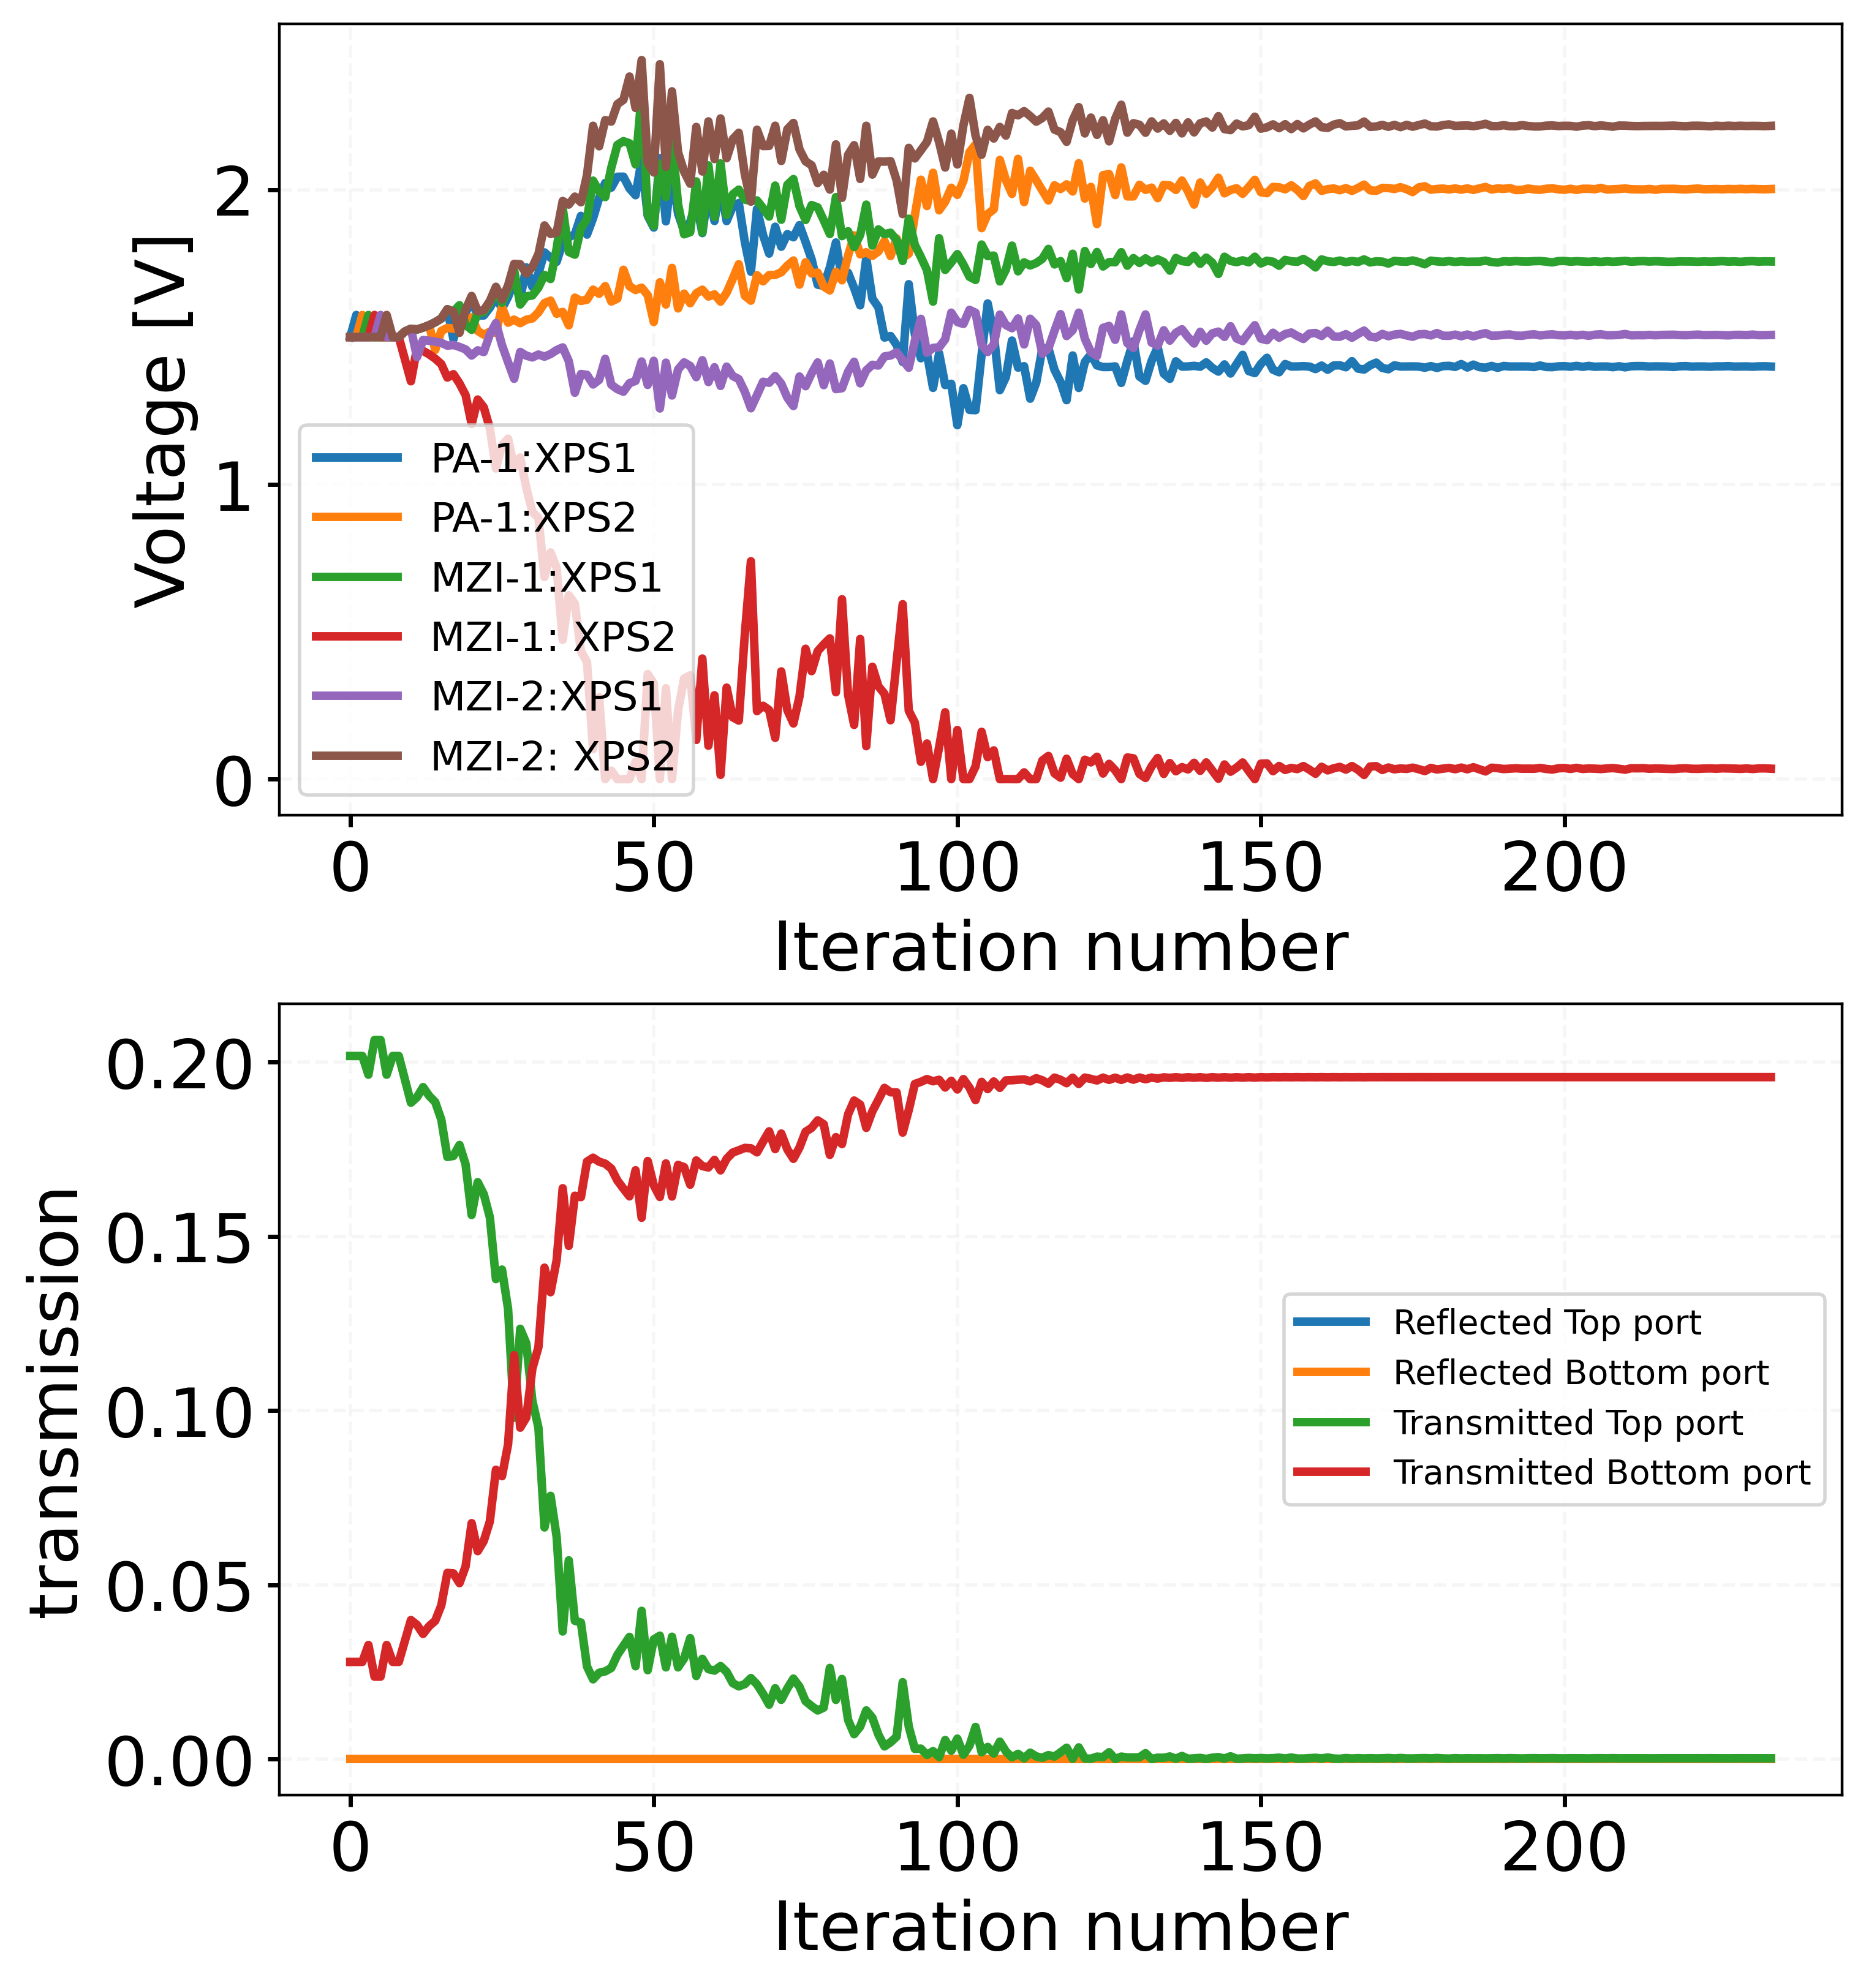

In [5]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([1, 0, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_sf,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [6]:
input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi_sf.smatrix @ input_state_reverse
print(np.abs(output_state_reverse)**2)

[2.21493638e-04 2.29418429e-01 1.28840786e-10 4.88658798e-12]


In [7]:
p_bidi_df.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi_df.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])

p_bidi_df.recursive_update()

In [8]:
def objective_function_df(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi_df.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi_df.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi_df.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi_df.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi_df.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi_df.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi_df.recursive_update()

  output_state = p_bidi_df.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_bottom_port

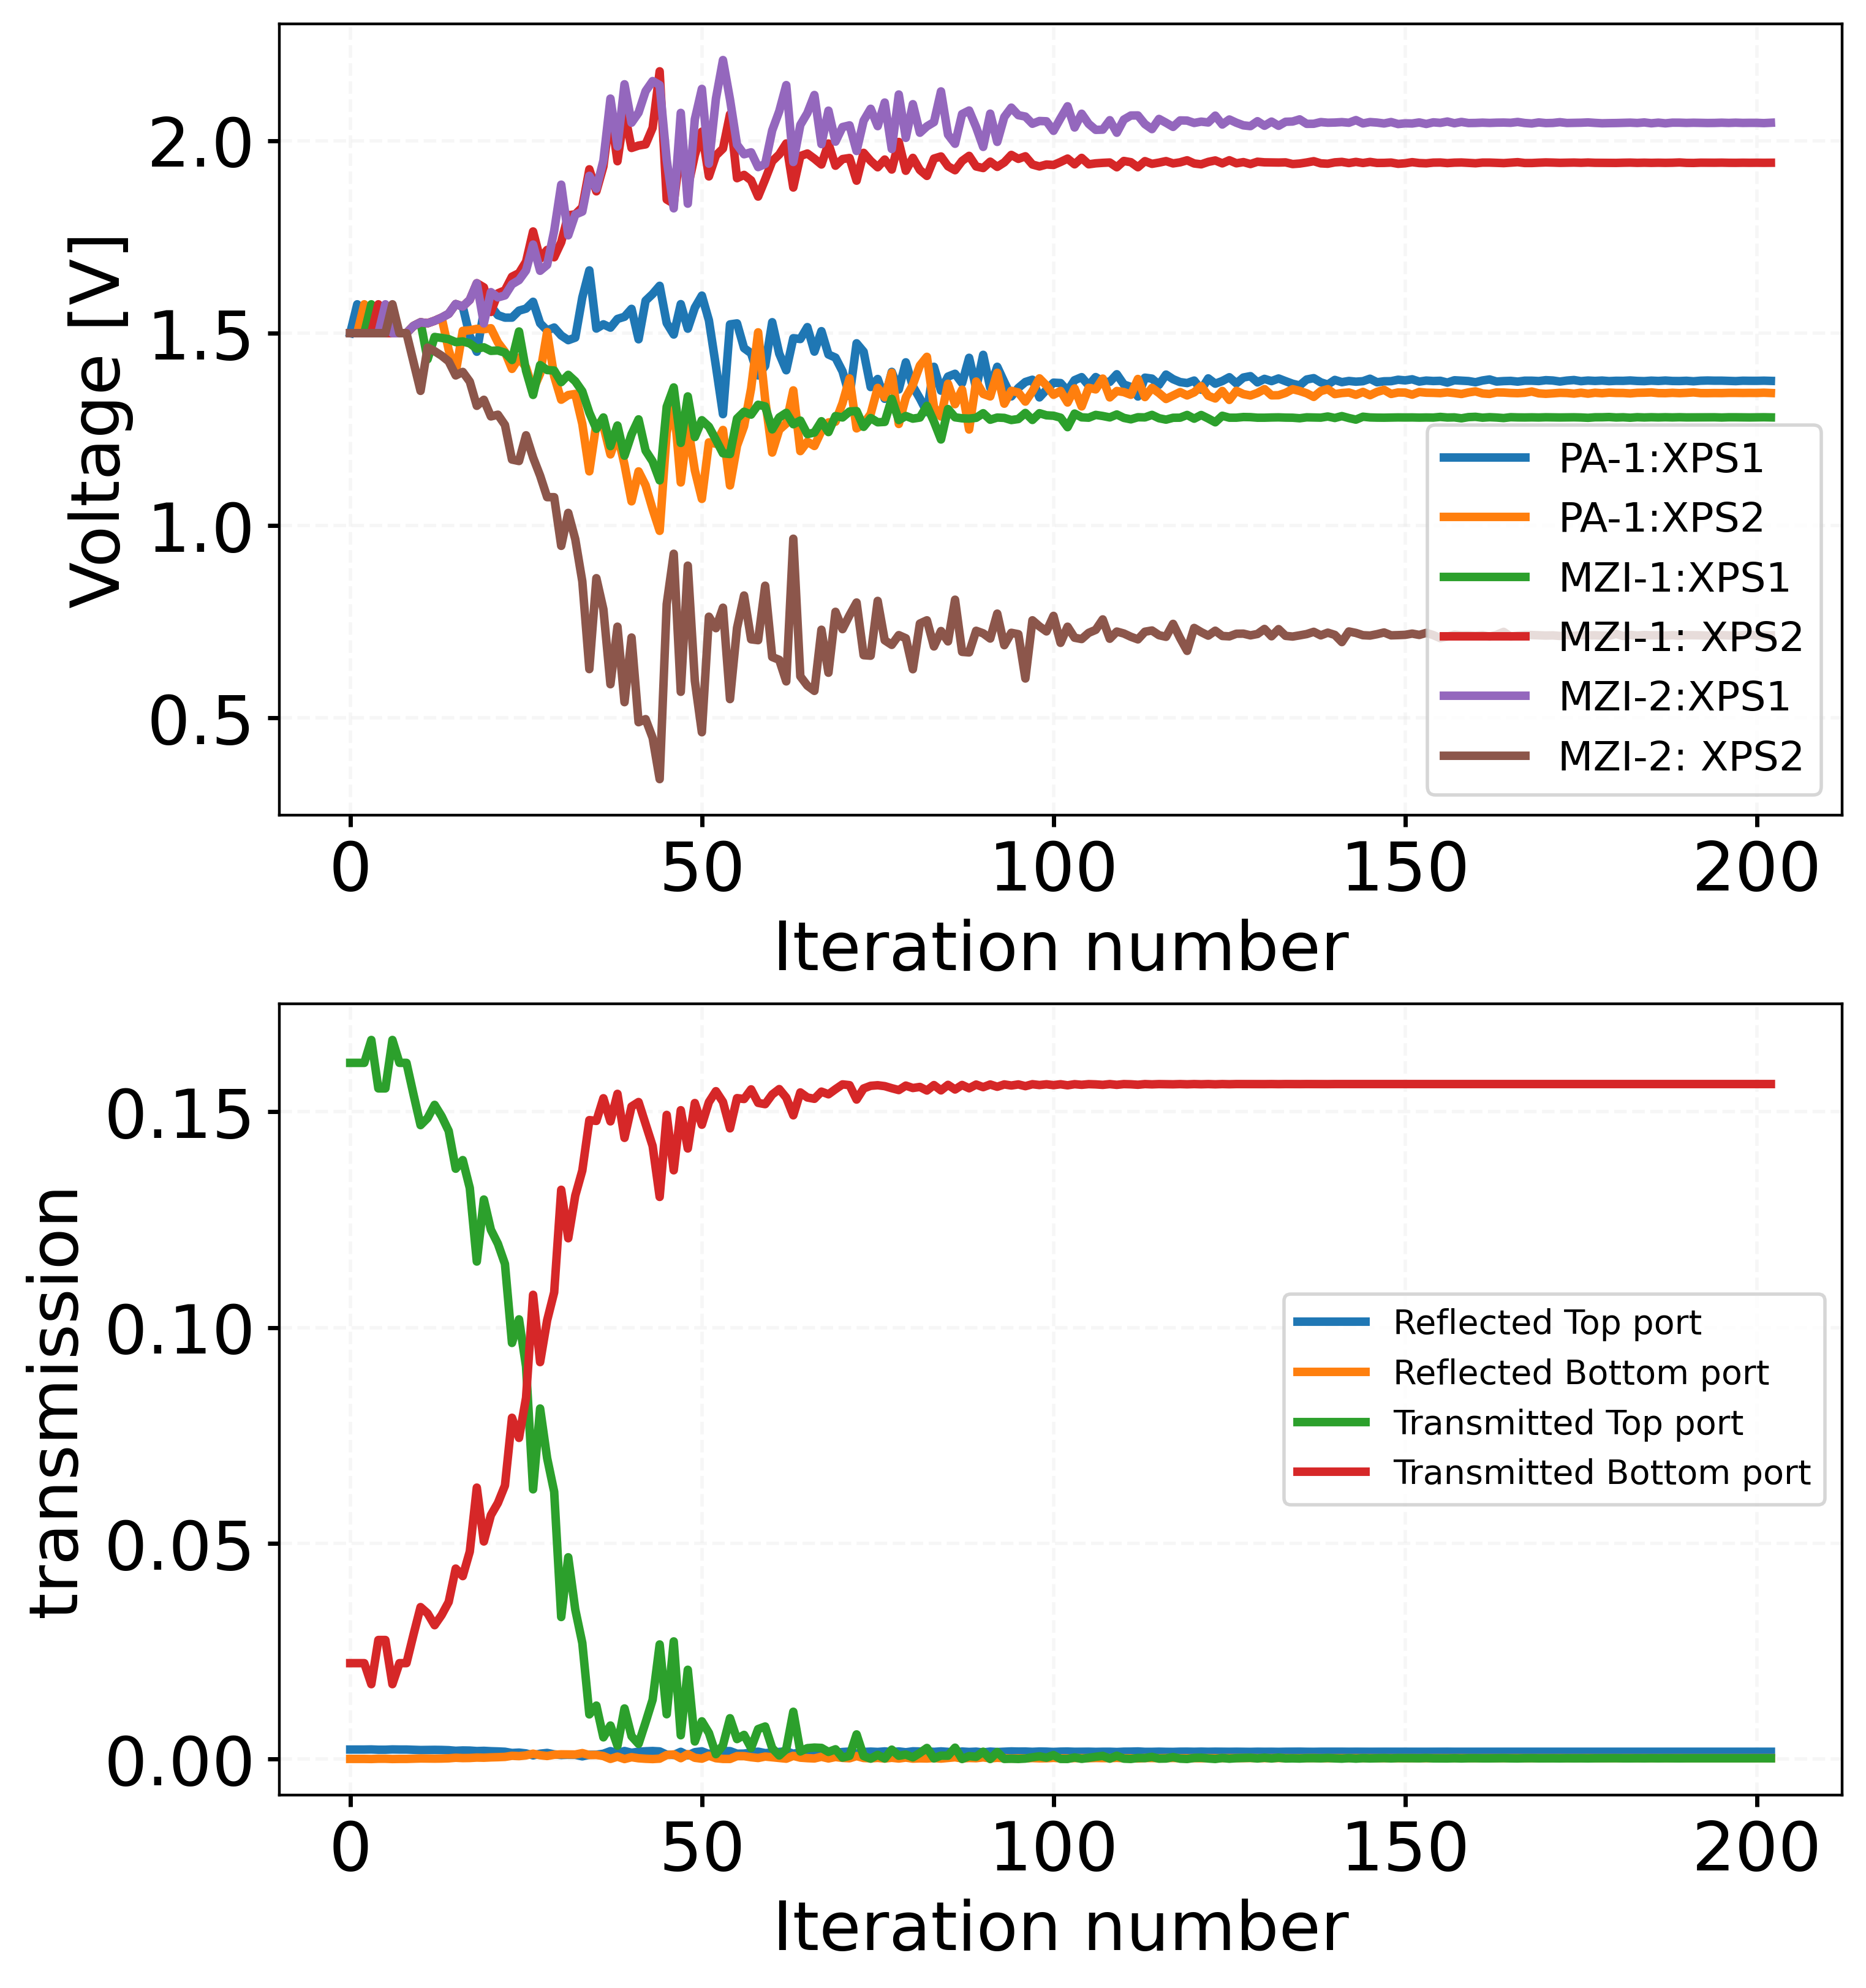

In [9]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([1, 0, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_df,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [10]:
input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi_df.smatrix @ input_state_reverse
print(np.abs(output_state_reverse)**2)

[1.75523804e-04 1.83362366e-01 2.11311477e-03 2.03451312e-04]


In [11]:
p_bidi.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])
p_bidi.fiber_3._rotation = (rotation_rx[2], rotation_ry[2], rotation_rz[2], rotation_delta[2])
p_bidi.fiber_4._rotation = (rotation_rx[3], rotation_ry[3], rotation_rz[3], rotation_delta[3])
p_bidi.fiber_5._rotation = (rotation_rx[4], rotation_ry[4], rotation_rz[4], rotation_delta[4])
p_bidi.fiber_6._rotation = (rotation_rx[5], rotation_ry[5], rotation_rz[5], rotation_delta[5])
p_bidi.fiber_7._rotation = (rotation_rx[6], rotation_ry[6], rotation_rz[6], rotation_delta[6])

p_bidi.recursive_update()

In [12]:
def objective_function_df(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi.recursive_update()

  output_state = p_bidi.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_bottom_port

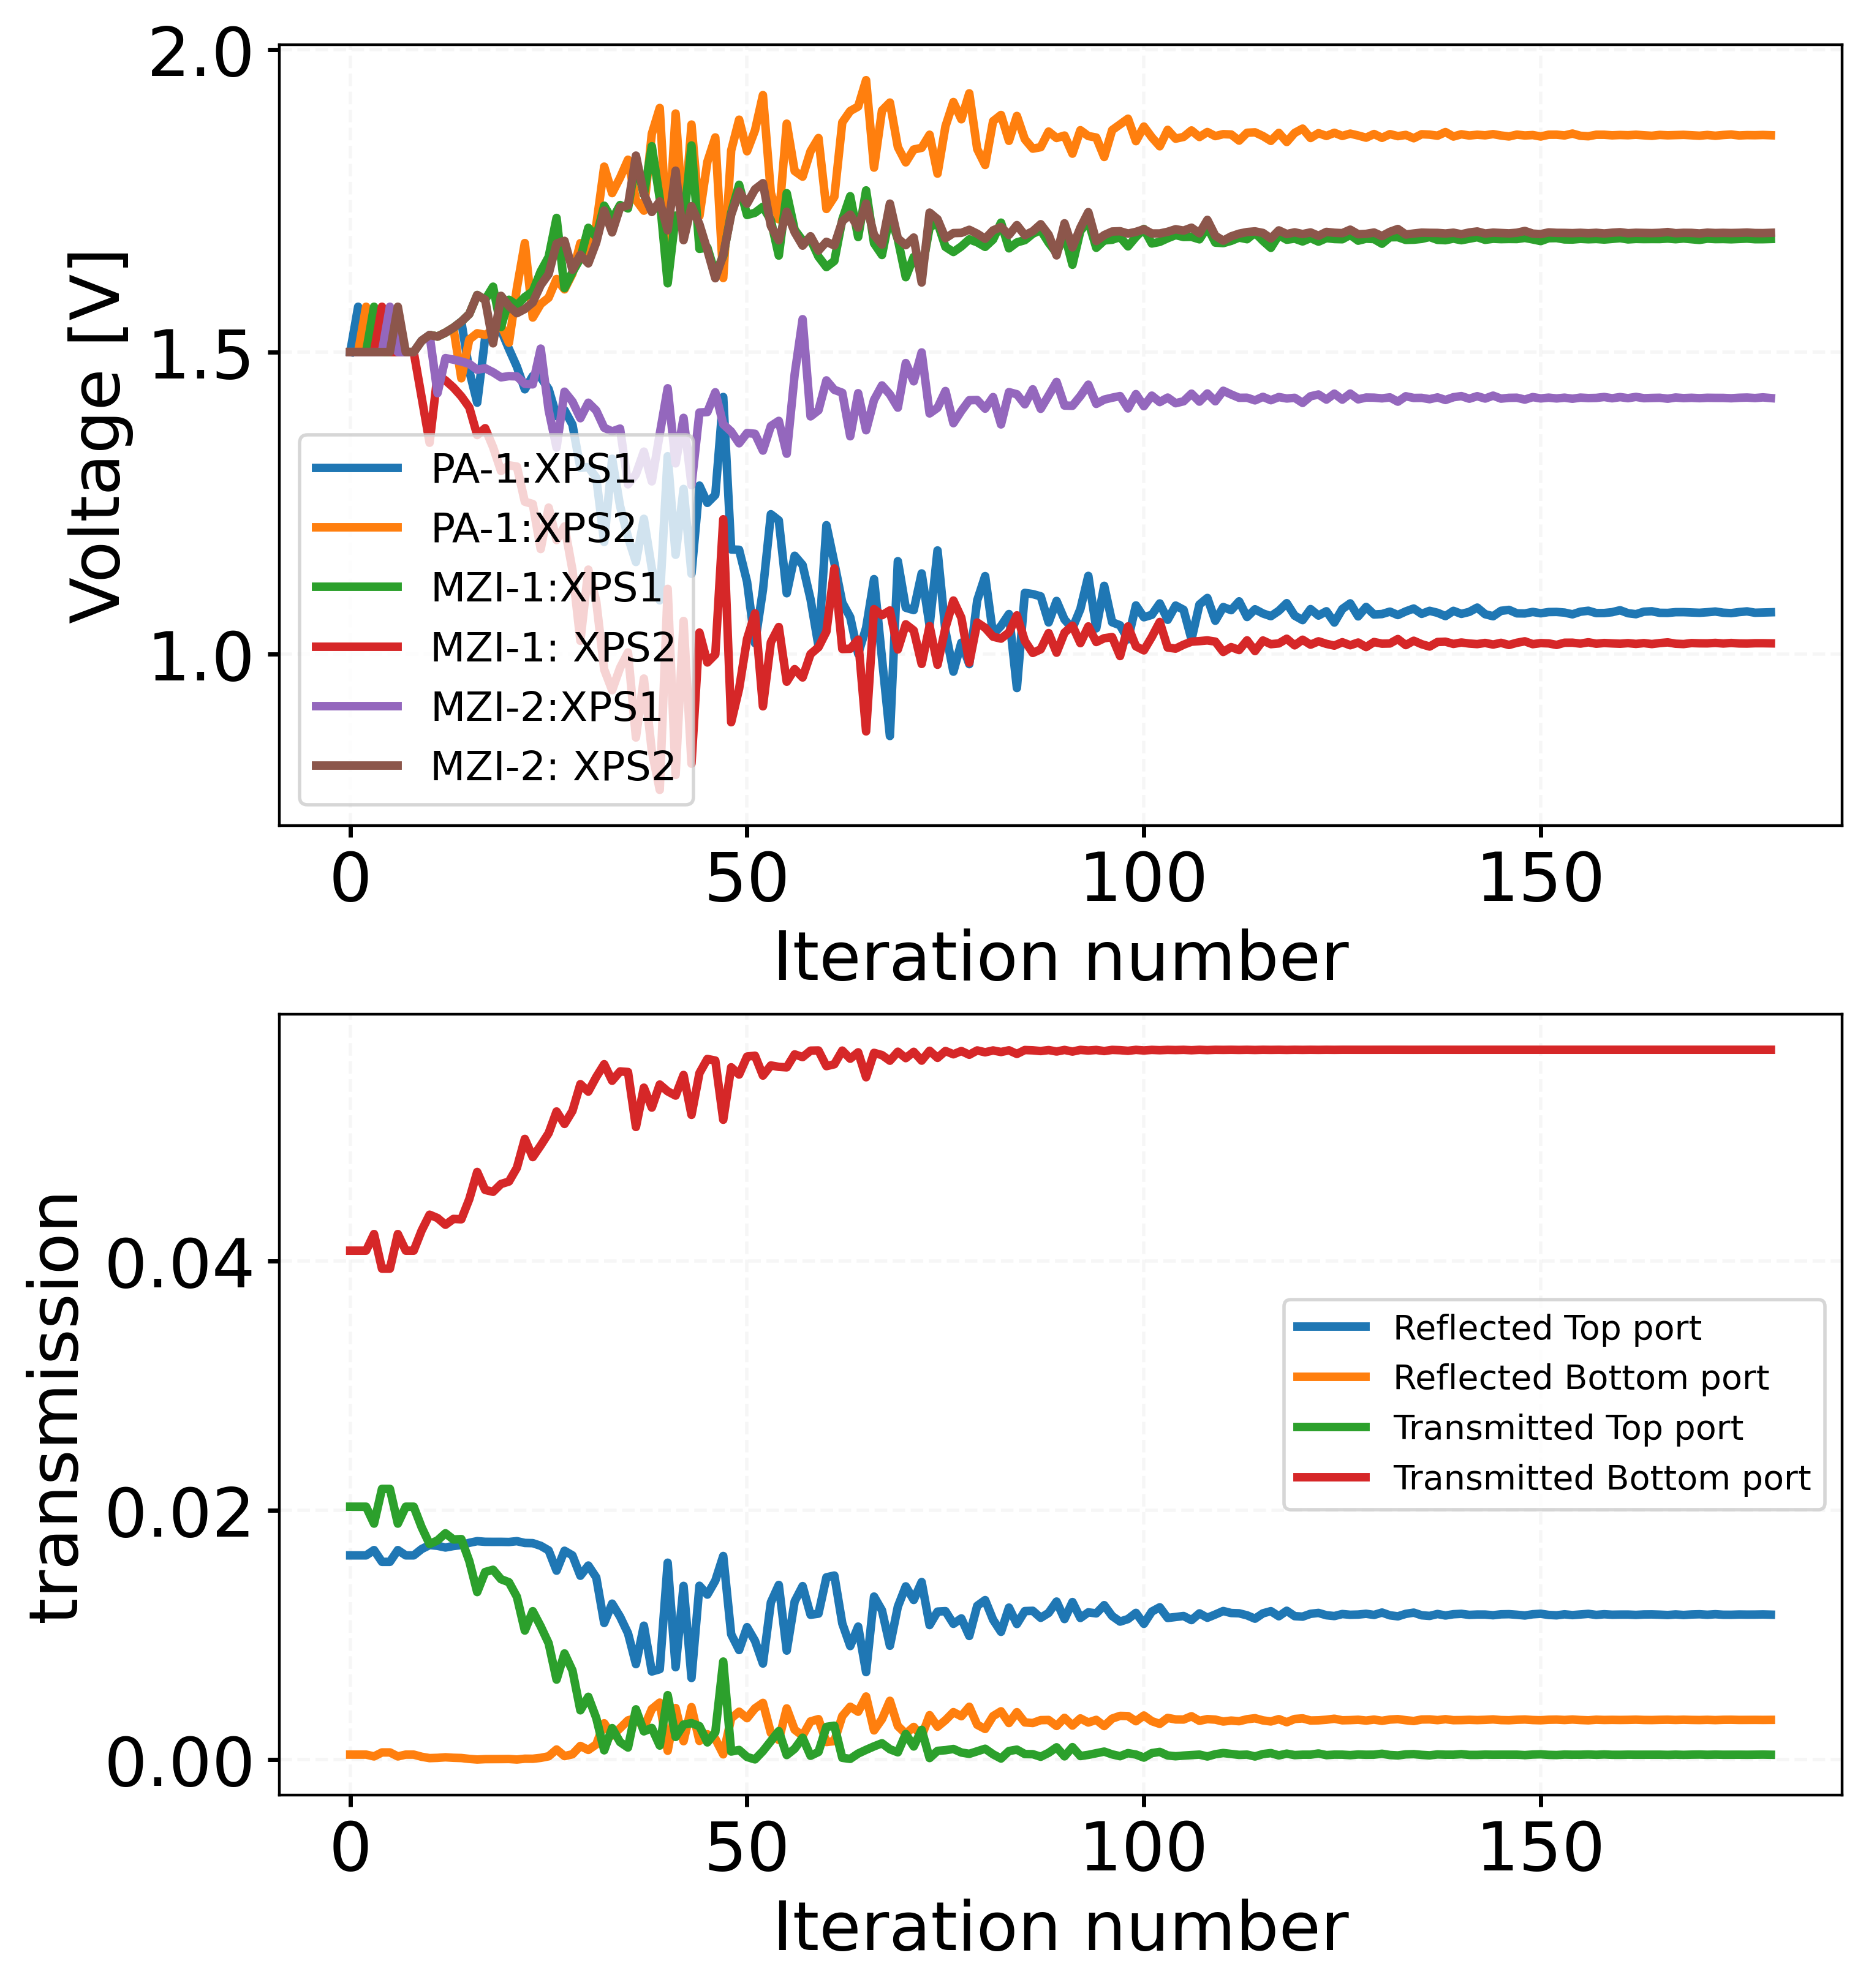

In [13]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([1, 0, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_df,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [14]:
input_state = np.array([1, 0, 0, 0])
output_state = p_bidi.smatrix @ input_state
print("Output state: ", np.abs(output_state)**2)

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse: ", np.abs(output_state_reverse)**2)

Output state:  [0.01162471 0.00318243 0.00038458 0.05694981]
Output state reverse:  [0.00038458 0.0561905  0.0006367  0.00250548]
